<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/load_GCC_gt_as_csv_and_model_train_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=203cf4a6c9851d807e922dafcba8f7ccc1388ccfe0315ee0f2dc706bded268ab
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.3 GB  | Proc size: 120.0 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [4]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        x_out = self.backend(density_map)
        density_map_out = self.output_layer(x_out)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [6]:
import numbers
import random
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import torch

class LabelNormalize(object):
    def __init__(self, para):
        self.para = para

    def __call__(self, tensor):
        # tensor = 1./(tensor+self.para).log()
        tensor = torch.from_numpy(np.array(tensor))
        tensor = tensor*self.para
        return tensor


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask, bbx=None):
        if bbx is None:
            for t in self.transforms:
                img, mask = t(img, mask)
            return img, mask
        for t in self.transforms:
            img, mask, bbx = t(img, mask, bbx)
        return img, mask, bbx

class RandomHorizontallyFlip(object):
    def __call__(self, img, mask, bbx=None):
        if random.random() < 0.5:
            if bbx is None:
                return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            xmin = w - bbx[:,3]
            xmax = w - bbx[:,1]
            bbx[:,1] = xmin
            bbx[:,3] = xmax
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT), bbx
        if bbx is None:
            return img, mask
        return img, mask, bbx

class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):

        w, h = img.size
        th, tw  = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

In [7]:
import os
import random
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    #path = "/content/drive/MyDrive/GCC_CSV_DataSet/Part 0/scene_00_0/csv_den_maps_k15_s4_544_960"
    gt_path = img_path.replace('.png','.csv').replace('pngs_544_960','csv_den_maps_k15_s4_544_960')
    img = Image.open(img_path)
    target = pd.read_csv(gt_path, sep=',', header=None).values
    target = target.astype(np.float32, copy=False)
    target = Image.fromarray(target)
    return img,target


class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, main_transform = None , img_transform=None, gt_transform = None, train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.main_transform = main_transform
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)

        if self.main_transform is not None:
            img, target = self.main_transform(img, target)
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.gt_transform is not None:
            target = self.gt_transform(target)   
        return img,target

In [8]:
model = TestNet()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [9]:
def get_image_path(file_path):
  file_path_list = file_path.split(" ")
  scene = file_path_list[3][4:]
  image_number = file_path_list[4]
  image_path = "/content/drive/MyDrive/GCC_CSV_DataSet/"+"Part"+"_"+scene[7]+scene+"/"+"pngs_544_960/"+image_number+".png"
  return image_path
  
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_

def extract_image_path_list(image_file, part):
  file_ = open(image_file, 'r')
  file_list = file_.readlines()
  image_path_list_train = []  
  for line in file_list:
      image_path_list_train.append(get_image_path(line))
  train_list = get_image_pathlist(image_path_list_train, part)
  print("data size: ",len(train_list))
  return train_list



In [10]:
train_list = '/content/drive/MyDrive/GCC/train_list.txt'
part0_train_list = extract_image_path_list(train_list, "Part_0")
part1_train_list = extract_image_path_list(train_list, "Part_1")
part2_train_list = extract_image_path_list(train_list, "Part_2")
part3_train_list = extract_image_path_list(train_list, "Part_3")
part4_train_list = extract_image_path_list(train_list, "Part_4")
part5_train_list = extract_image_path_list(train_list, "Part_5")
part6_train_list = extract_image_path_list(train_list, "Part_6")
part7_train_list = extract_image_path_list(train_list, "Part_7")
part8_train_list = extract_image_path_list(train_list, "Part_8")
part9_train_list = extract_image_path_list(train_list, "Part_9")

data size:  1320
data size:  1160
data size:  1258
data size:  1135
data size:  1055
data size:  1037
data size:  1000
data size:  1026
data size:  992
data size:  1461


In [11]:
test_list = '/content/drive/MyDrive/GCC/test_list.txt'
part0_test_list = extract_image_path_list(test_list, "Part_0")
part1_test_list = extract_image_path_list(test_list, "Part_1")
part2_test_list = extract_image_path_list(test_list, "Part_2")
part3_test_list = extract_image_path_list(test_list, "Part_3")
part4_test_list = extract_image_path_list(test_list, "Part_4")
part5_test_list = extract_image_path_list(test_list, "Part_5")
part6_test_list = extract_image_path_list(test_list, "Part_6")
part7_test_list = extract_image_path_list(test_list, "Part_7")
part8_test_list = extract_image_path_list(test_list, "Part_8")
part9_test_list = extract_image_path_list(test_list, "Part_9")

data size:  473
data size:  385
data size:  415
data size:  368
data size:  356
data size:  335
data size:  341
data size:  322
data size:  335
data size:  438


In [12]:
train_data = part0_train_list + part1_train_list+part2_train_list+part3_train_list+part4_train_list+part5_train_list+part6_train_list+part7_train_list+part8_train_list+part9_train_list
test_data = part0_test_list + part1_test_list+part2_test_list+part3_test_list+part4_test_list+part5_test_list+part6_test_list+part7_test_list+part8_test_list+part9_test_list

In [13]:
sou_main_transform = Compose([
        RandomCrop((480,480)),
        RandomHorizontallyFlip(),
        # Rand_Augment()
    ])
train_loader = torch.utils.data.DataLoader(ListDataset(train_data,shuffle=True,
                                                                main_transform = sou_main_transform,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [14]:
test_loader = torch.utils.data.DataLoader(ListDataset(test_data,shuffle=False,
                                                                main_transform = None,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [15]:
lr = 1e-5
criterion = nn.MSELoss(size_average=False).cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.95,weight_decay=5 * 1e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, cur_val):
        self.cur_val = cur_val
        self.sum += cur_val
        self.count += 1
        self.avg = self.sum / self.count

In [17]:

def mae_mse_update(pred,label,maes,mses=None,ssims=None,psnrs=None,losses=None,cls_id=None):
        for num in range(pred.size()[0]):
            sub_pred = pred[num].data.cpu().squeeze().numpy()/ 100
            sub_label = label[num].data.cpu().squeeze().numpy() / 100
            pred_cnt = np.sum(sub_pred)
            gt_cnt =   np.sum(sub_label)
            mae = abs(pred_cnt - gt_cnt)
            mse = (pred_cnt - gt_cnt)*(pred_cnt - gt_cnt)

            if ssims and psnrs is not None:
                ssims.update(get_ssim(sub_label,sub_pred))
                psnrs.update(get_psnr(sub_label,sub_pred))

            if cls_id is not None:
                maes.update(mae,cls_id)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item(),cls_id)
                if mses is not None:
                    mses.update(mse,cls_id)
            else:
                maes.update(mae)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item())
                if mses is not None:
                    mses.update(mse)

        return pred_cnt,gt_cnt

In [18]:
PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNet_checkpoint_gcc_data_Whole_aug.pth'
end_epoch = 100
start_epoch = 0
if (os.path.isfile(PATH))==True:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  print("Successfully load the check point")
else:
  print("No check point Available!!!")
print(end_epoch , start_epoch)

Successfully load the check point
100 92


In [19]:
train_mae_file = open("/content/drive/MyDrive/GCC_CSV_DataSet/train_mae_part1and0.txt","a")
test_mae_file = open("/content/drive/MyDrive/GCC_CSV_DataSet/test_mae_part1and0.txt","a")
train_mae_file.truncate(0)
test_mae_file.truncate(0)

0

In [20]:
test_best_mae = 33.85

In [ ]:
for epoch in range(start_epoch,end_epoch):
    losses = AverageMeter()
    model.train()
    train_mae = AverageMeter()
    train_mse = AverageMeter()
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        img = Variable(img) 
        output = model(img)

        loss = criterion(output.squeeze(), target.squeeze().cuda())
        losses.update(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sou_pred_cnt, sou_label_cnt = mae_mse_update(output, target, train_mae, train_mse)
        if i % 1000 == 0:
            print('Epoch {}, Loss={:.4f} s_gt={:.1f} s_pre={:.1f}, lr={:.4f}'.format(
                    epoch, loss.item(), sou_label_cnt,sou_pred_cnt, optimizer.param_groups[0]['lr']*10000))
    
    scheduler.step()  
    print('train_mae_sou', float(train_mae.avg), epoch)
    print('train_mse_sou', float(np.sqrt(train_mse.avg)), epoch)
    train_mae_file.write(str(train_mae.avg))
    train_mae_file.write("\n")
  
    print("testing...................")  
    with torch.no_grad():
      model.eval()
      test_mae = AverageMeter()
      test_mse = AverageMeter()
      for j, (img_test, target_test) in enumerate(test_loader):
          img_test = img_test.cuda()
          img_test = Variable(img_test)   
          output_test = model(img_test)

          sou_pred_cnt_test, sou_label_cnt_test = mae_mse_update(output_test, target_test, test_mae, test_mse)
          if j % 1000 == 0:
            print('Epoch {}, s_gt={:.1f} s_pre={:.1f} '.format(epoch, sou_label_cnt_test,sou_pred_cnt_test))
      print('test_mae_sou', float(test_mae.avg), epoch)
      print('test_mse_sou', float(np.sqrt(test_mse.avg)), epoch)
      if test_mae.avg<test_best_mae:
        test_best_mae = test_mae.avg
        print("Best Train MAE", test_best_mae)
        MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNetGCC_whole_data_withbackend_5.pth'
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
      test_mae_file.write(str(test_mae.avg))
      test_mae_file.write("\n")
      torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH) 

train_mae_file.close()
test_mae_file.close()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3847: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3792: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Epoch 92, Loss=16087.9707 s_gt=912.3 s_pre=866.4, lr=0.0524
Epoch 92, Loss=6658.6553 s_gt=7.0 s_pre=9.6, lr=0.0524
Epoch 92, Loss=1092.4775 s_gt=59.0 s_pre=58.5, lr=0.0524
Epoch 92, Loss=427.2452 s_gt=12.0 s_pre=10.8, lr=0.0524
Epoch 92, Loss=24394.6875 s_gt=17.7 s_pre=16.8, lr=0.0524
Epoch 92, Loss=21833.6562 s_gt=103.4 s_pre=103.9, lr=0.0524
train_mae_sou 12.30828899062769 92
train_mse_sou 24.738398892519637 92
testing...................
Epoch 92, s_gt=1895.6 s_pre=1772.4 
Epoch 92, s_gt=565.7 s_pre=506.7 
test_mae_sou 57.306059340620116 92
test_mse_sou 146.34040528077978 92
Epoch 93, Loss=17690.6543 s_gt=941.6 s_pre=851.5, lr=0.0524
Epoch 93, Loss=6396.9092 s_gt=8.0 s_pre=10.0, lr=0.0524
Epoch 93, Loss=777.7853 s_gt=34.3 s_pre=31.5, lr=0.0524
Epoch 93, Loss=227.8517 s_gt=11.4 s_pre=12.9, lr=0.0524
Epoch 93, Loss=48220.7344 s_gt=16.0 s_pre=15.7, lr=0.0524
Epoch 93, Loss=17485.0527 s_gt=126.2 s_pre=115.0, lr=0.0524
train_mae_sou 12.077308747018643 93
train_mse_sou 24.368226333588304 9

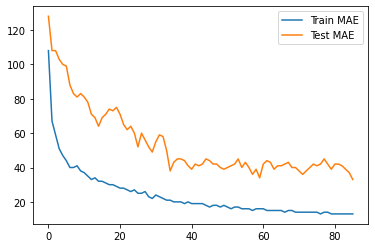

In [6]:
import matplotlib.pyplot as plt


x1 = [i for i in range(0,86)]
y1 = [108 ,67]+[59, 51, 47]+[44, 40, 40 , 41,38,37 , 35,33,34,32,32,31,30,30,29,28,28,27,26,27,25,25 , 26 , 23 , 22 , 24, 23,22,21,21  ,20 , 20, 20,19 ,20,19,19,19,19,18,17,18,18,17,18,17,16,17,17,16,16,16,15,16,16,16,15,15,15,15,15,14,15,15,14,14,14,14,14,14,14,13,14,14,13,13,13,13,13,13,13]
y2 = [128,108]+[108, 103, 100]+[99, 88, 83,81 , 83,81,78,71,69,64,69,71,74,73,75,71,65,62,64,60,52, 60, 56 , 52 , 49 , 55, 59,58,50,38 , 43,45 ,45,44,41,39,42,41,42,45,44,42,42,40,39,40,41,42,45,40,43,40,36,39,34,42,44,43,39,41,41,42,43,40,40,38,36,38,40,42,41,42,45,42,39,42,42,41,39,37,33]
plt.plot(x1, y1)
plt.plot(x1, y2)

plt.legend(["Train MAE", "Test MAE"])

In [ ]:
Epoch 87, Loss=873.5103 s_gt=12.0 s_pre=8.0, lr=0.0545
Epoch 87, Loss=525.8693 s_gt=6.9 s_pre=10.9, lr=0.0545
Epoch 87, Loss=584.4041 s_gt=81.1 s_pre=80.8, lr=0.0545
Epoch 87, Loss=4968.6870 s_gt=12.9 s_pre=12.6, lr=0.0545
Epoch 87, Loss=735.8824 s_gt=38.0 s_pre=34.6, lr=0.0545
Epoch 87, Loss=4866.0815 s_gt=65.1 s_pre=58.8, lr=0.0545
train_mae_sou 12.479149307519176 87
train_mse_sou 24.888943948175456 87
testing...................
Epoch 87, s_gt=1895.6 s_pre=1803.1 
Epoch 87, s_gt=565.7 s_pre=465.2 
test_mae_sou 55.79668885779482 87
test_mse_sou 134.97065540912124 87
Epoch 88, Loss=509.4996 s_gt=2.0 s_pre=3.7, lr=0.0545
Epoch 88, Loss=447.1147 s_gt=5.0 s_pre=8.5, lr=0.0545
Epoch 88, Loss=2475.3442 s_gt=166.8 s_pre=170.9, lr=0.0545
Epoch 88, Loss=1276.7296 s_gt=13.2 s_pre=10.1, lr=0.0545
Epoch 88, Loss=1593.9288 s_gt=102.3 s_pre=105.1, lr=0.0545
Epoch 88, Loss=4395.4434 s_gt=70.4 s_pre=58.9, lr=0.0545
train_mae_sou 12.692552064458864 88
train_mse_sou 25.586126889527446 88
testing...................
Epoch 88, s_gt=1895.6 s_pre=1835.4 
Epoch 88, s_gt=565.7 s_pre=541.4 
test_mae_sou 37.40849148474175 88
test_mse_sou 100.68114825464883 88
Epoch 89, Loss=959.3674 s_gt=2.0 s_pre=5.5, lr=0.0535
Epoch 89, Loss=536.9408 s_gt=5.9 s_pre=9.7, lr=0.0535
Epoch 89, Loss=2202.5764 s_gt=166.5 s_pre=156.0, lr=0.0535
Epoch 89, Loss=1002.4481 s_gt=9.0 s_pre=12.9, lr=0.0535
Epoch 89, Loss=901.8981 s_gt=49.4 s_pre=53.0, lr=0.0535
Epoch 89, Loss=2963.7048 s_gt=54.2 s_pre=43.6, lr=0.0535
train_mae_sou 12.66438981682441 89
train_mse_sou 26.250692507467253 89
testing...................
Epoch 89, s_gt=1895.6 s_pre=1846.3 
Epoch 89, s_gt=565.7 s_pre=524.2 
test_mae_sou 39.99199535942888 89
test_mse_sou 110.36035246792723 89

Epoch 90, Loss=646.5372 s_gt=35.8 s_pre=39.6, lr=0.0535
Epoch 90, Loss=5416.6172 s_gt=285.0 s_pre=322.8, lr=0.0535
Epoch 90, Loss=1083.6299 s_gt=113.3 s_pre=121.8, lr=0.0535
Epoch 90, Loss=69312.6406 s_gt=57.4 s_pre=52.4, lr=0.0535
Epoch 90, Loss=4491.6001 s_gt=195.3 s_pre=202.7, lr=0.0535
Epoch 90, Loss=10992.9209 s_gt=15.4 s_pre=16.8, lr=0.0535
train_mae_sou 12.014944836386304 90
train_mse_sou 24.777539003662486 90
testing...................
Epoch 90, s_gt=1895.6 s_pre=1820.9 
Epoch 90, s_gt=565.7 s_pre=509.8 
test_mae_sou 43.206938930371905 90
test_mse_sou 121.20153292950876 90
Epoch 91, Loss=750.8062 s_gt=39.0 s_pre=38.7, lr=0.0535
Epoch 91, Loss=4567.5249 s_gt=242.9 s_pre=251.1, lr=0.0535
Epoch 91, Loss=1083.3939 s_gt=98.4 s_pre=102.7, lr=0.0535
Epoch 91, Loss=53011.6680 s_gt=64.0 s_pre=62.9, lr=0.0535
Epoch 91, Loss=17944.6602 s_gt=538.2 s_pre=535.7, lr=0.0535
Epoch 91, Loss=10476.9678 s_gt=23.0 s_pre=24.8, lr=0.0535
train_mae_sou 12.407590258023117 91
train_mse_sou 24.683947901944876 91
testing...................
Epoch 91, s_gt=1895.6 s_pre=1806.7 
Epoch 91, s_gt=565.7 s_pre=517.1 
test_mae_sou 48.766485980045516 91
test_mse_sou 125.55581661519332 91